## Project: E-Commerce Customer Segmentation
### Table of Contents
1. Data Preparation & Feature Selection
   1. Load Your Data
   2. Merge Demographic Info into Customers Table
   3. Summarize Transaction Data for Each Customer
   4. Merge Transaction Summary Back into Customers
   5. Create Derived Features
   6. Encode Categorical Features
   7. Select the Final Feature Columns for Clustering
   8. Scale the Numeric Features
2. Model Development (K-Means Example)
   1. Unsupervised Learning: K-Means Clustering
   2. Finalize the Model with the Best k 
3. Segment Analysis
4. Coupon Strategy Recommendations
5. Trying Other Clustering Methods
   1. DBSCAN
   2. Agglomerative Clustering (Hierarchical Clustering)
   3. Visualize the Clusters using PCA for Dimensionality Reduction
6. Presenting Your Findings
   1. Visualize Clusters using PCA Scatter Plot
   2. Cluster Summary Table
   3. Distribution of Usage Frequency per Cluster
   4. Number of Customers per Cluster
   5. Coupon Strategy Recommendations based on Cluster Metrics

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation & Feature Selection

## 1. Load Data

In [29]:
# Load the dataset
xls = pd.ExcelFile("/kaggle/input/e-commerce-dataset/E-commerce_data.xlsx")

# Load relevant sheets
customers = pd.read_excel(xls, sheet_name="customers")
genders = pd.read_excel(xls, sheet_name="genders")
cities = pd.read_excel(xls, sheet_name="cities")
transactions = pd.read_excel(xls, sheet_name="transactions")
branches = pd.read_excel(xls, sheet_name="branches")
merchants = pd.read_excel(xls, sheet_name="merchants")

# Display Data
print("Customers:")
print(customers.head())

print("\nGenders:")
print(genders.head())

print("\nCities:")
print(cities.head())

print("\nTransactions:")
print(transactions.head())

print("\nBranches:")
print(branches.head())

print("\nMerchants:")
print(merchants.head())

Customers:
   customer_id  join_date  city_id  gender_id
0            1 2022-01-08        7          1
1            2 2023-05-02       20          2
2            3 2023-05-14       15          1
3            4 2022-11-25       11          2
4            5 2023-04-26        8          1

Genders:
   gender_id gender_name
0          1        Male
1          2      Female

Cities:
   city_id         city_name
0        1             Cairo
1        2        Alexandria
2        3              Giza
3        4  Shubra El-Kheima
4        5         Port Said

Transactions:
   transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12             burned   

  coupon_

## 2. Merge Demographic Info into Customers Table

In [30]:
# Merge customers with genders to get gender_name
customers = customers.merge(genders, on="gender_id", how="left")

# Merge customers with cities to get city_name
customers = customers.merge(cities, on="city_id", how="left")

# Merge branches & merchants
branches = branches.merge(merchants, on="merchant_id", how="left")

# Display Data
print("Customers:")
print(customers.head())

print("\nBranches:")
print(branches.head())

Customers:
   customer_id  join_date  city_id  gender_id gender_name            city_name
0            1 2022-01-08        7          1        Male             Mansoura
1            2 2023-05-02       20          2      Female                Sohag
2            3 2023-05-14       15          1        Male                Aswan
3            4 2022-11-25       11          2      Female             Ismailia
4            5 2023-04-26        8          1        Male  El-Mahalla El-Kubra

Branches:
   branch_id  merchant_id                   merchant_name
0          1           11     Smith, Lawson and Hernandez
1          2           18                       Lewis LLC
2          3            8                   Medina-Foster
3          4           15                    Butler-Gomez
4          5            9  Campbell, Shaffer and Martinez


## 3. Summarize Transaction Data for Each Customer

In [31]:
# flags burned transactions
transactions["is_burned"] = (transactions["transaction_status"] == "burned").astype(int)

# Group by customer_id and aggregate
transaction_summary = transactions.groupby("customer_id").agg(
    total_transactions = ("transaction_id", "count"),
    total_burned       = ("is_burned", "sum"),
    last_transaction_date = ("transaction_date", "max")
).reset_index()


max_date = transactions["transaction_date"].max()  
transaction_summary["recency"] = (pd.to_datetime(max_date) - 
                                  pd.to_datetime(transaction_summary["last_transaction_date"])).dt.days

print(transaction_summary)

     customer_id  total_transactions  total_burned last_transaction_date  \
0              1                   7             3            2024-05-26   
1              2                   3             1            2023-10-21   
2              3                   5             1            2024-07-05   
3              4                   1             0            2023-01-15   
4              5                   4             3            2024-07-02   
..           ...                 ...           ...                   ...   
984          996                   3             0            2024-05-09   
985          997                   3             1            2024-01-23   
986          998                   4             3            2024-06-27   
987          999                   4             4            2024-04-09   
988         1000                   2             1            2024-04-27   

     recency  
0         49  
1        267  
2          9  
3        546  
4         12

## 4. Merge Transaction Summary Back into Customers

In [32]:
df = customers.merge(transaction_summary, on="customer_id", how="left")

# Fill missing numeric values with 0 
'''df["total_transactions"].fillna(0, inplace=True)
df["total_burned"].fillna(0, inplace=True)
df["recency"].fillna(df["recency"].max(), inplace=True)'''  

df["total_transactions"] = df["total_transactions"].fillna(0)
df["total_burned"] = df["total_burned"].fillna(0)
df["recency"] = df["recency"].fillna(df["recency"].max())

df.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,total_burned,last_transaction_date,recency
0,1,2022-01-08,7,1,Male,Mansoura,7.0,3.0,2024-05-26,49.0
1,2,2023-05-02,20,2,Female,Sohag,3.0,1.0,2023-10-21,267.0
2,3,2023-05-14,15,1,Male,Aswan,5.0,1.0,2024-07-05,9.0
3,4,2022-11-25,11,2,Female,Ismailia,1.0,0.0,2023-01-15,546.0
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,3.0,2024-07-02,12.0


## 5. Create Derived Features

In [33]:
def calc_usage_freq(row):
    if row["total_transactions"] > 0:
        return row["total_burned"] / row["total_transactions"]
    return 0

df["usage_frequency"] = df.apply(calc_usage_freq, axis=1)

df.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,total_burned,last_transaction_date,recency,usage_frequency
0,1,2022-01-08,7,1,Male,Mansoura,7.0,3.0,2024-05-26,49.0,0.428571
1,2,2023-05-02,20,2,Female,Sohag,3.0,1.0,2023-10-21,267.0,0.333333
2,3,2023-05-14,15,1,Male,Aswan,5.0,1.0,2024-07-05,9.0,0.200000
3,4,2022-11-25,11,2,Female,Ismailia,1.0,0.0,2023-01-15,546.0,0.000000
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,3.0,2024-07-02,12.0,0.750000


## 6. Encode Categorical Features

In [34]:
# One-Hot Encoding for gender_name and city_name.
df = pd.get_dummies(df, columns=["gender_name", "city_name"], drop_first=True)
df.head()

,customer_id,join_date,city_id,gender_id,total_transactions,total_burned,last_transaction_date,recency,usage_frequency,gender_name_Male,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,1,2022-01-08,7,1,7.0,3.0,2024-05-26,49.0,0.428571,True,...,False,True,False,False,False,False,False,False,False,False
1,2,2023-05-02,20,2,3.0,1.0,2023-10-21,267.0,0.333333,False,...,False,False,False,False,False,False,True,False,False,False
2,3,2023-05-14,15,1,5.0,1.0,2024-07-05,9.0,0.200000,True,...,False,False,False,False,False,False,False,False,False,False
3,4,2022-11-25,11,2,1.0,0.0,2023-01-15,546.0,0.000000,False,...,True,False,False,False,False,False,False,False,False,False
4,5,2023-04-26,8,1,4.0,3.0,2024-07-02,12.0,0.750000,True,...,False,False,False,False,False,False,False,False,False,False


## 7. Select the Final Feature Columns for Clustering

In [35]:
# want these numeric columns plus the new dummies
feature_cols = [
    "total_transactions",
    "total_burned",
    "usage_frequency",
    "recency",
] + [col for col in df.columns if col.startswith("gender_name_") or col.startswith("city_name_")]

X = df[feature_cols].copy()
X

,total_transactions,total_burned,usage_frequency,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,7.0,3.0,0.428571,49.0,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,3.0,1.0,0.333333,267.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,5.0,1.0,0.200000,9.0,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.0,0.0,0.000000,546.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,4.0,3.0,0.750000,12.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,0.0,0.000000,66.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
996,3.0,1.0,0.333333,173.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
997,4.0,3.0,0.750000,17.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
998,4.0,4.0,1.000000,96.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


## 8. Scale the Numeric Features

In [36]:
# Scale only the numeric columns to have mean=0, std=1
numeric_cols = ["total_transactions", "total_burned", "usage_frequency", "recency"]
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X

,total_transactions,total_burned,usage_frequency,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,0.861781,0.308227,-0.272757,-0.406907,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,-0.861781,-0.965440,-0.639388,0.918325,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.000000,-0.965440,-1.152671,-0.650069,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.723562,-1.602273,-1.922595,2.614378,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,-0.430890,0.308227,0.964622,-0.631832,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.861781,-1.602273,-1.922595,-0.303563,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
996,-0.861781,-0.965440,-0.639388,0.346895,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
997,-0.430890,0.308227,0.964622,-0.601436,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
998,-0.430890,0.945061,1.927028,-0.121192,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [37]:
print("Feature preparation complete. 'X' is ready for clustering.\n")
print("Sample of final feature set:\n", X.head())

Feature preparation complete. 'X' is ready for clustering.

Sample of final feature set:
    total_transactions  total_burned  usage_frequency   recency  \
0            0.861781      0.308227        -0.272757 -0.406907   
1           -0.861781     -0.965440        -0.639388  0.918325   
2            0.000000     -0.965440        -1.152671 -0.650069   
3           -1.723562     -1.602273        -1.922595  2.614378   
4           -0.430890      0.308227         0.964622 -0.631832   

   gender_name_Male  city_name_Aswan  city_name_Asyut  city_name_Beni Suef  \
0              True            False            False                False   
1             False            False            False                False   
2              True             True            False                False   
3             False            False            False                False   
4              True            False            False                False   

   city_name_Cairo  city_name_Damanhur  ... 

# 2. Model Development (K-Means Example)

## 1. Unsupervised Learning: K-Means Clustering

In [38]:
# Evaluate K-Means with different k values
inertia_values = []
silhouette_scores = []
k_values = range(2, 11)  # trying k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k,  n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    inertia = kmeans.inertia_
    sil_score = silhouette_score(X, cluster_labels)
    inertia_values.append(inertia)
    silhouette_scores.append(sil_score)
    print(f"k = {k}: Inertia = {inertia:.2f}, Silhouette Score = {sil_score:.3f}")

k = 2: Inertia = 3858.62, Silhouette Score = 0.215
k = 3: Inertia = 3247.08, Silhouette Score = 0.220
k = 4: Inertia = 2752.60, Silhouette Score = 0.210
k = 5: Inertia = 2481.01, Silhouette Score = 0.179
k = 6: Inertia = 2301.87, Silhouette Score = 0.182
k = 7: Inertia = 2188.94, Silhouette Score = 0.168
k = 8: Inertia = 2062.35, Silhouette Score = 0.158
k = 9: Inertia = 1987.52, Silhouette Score = 0.143
k = 10: Inertia = 1909.56, Silhouette Score = 0.153


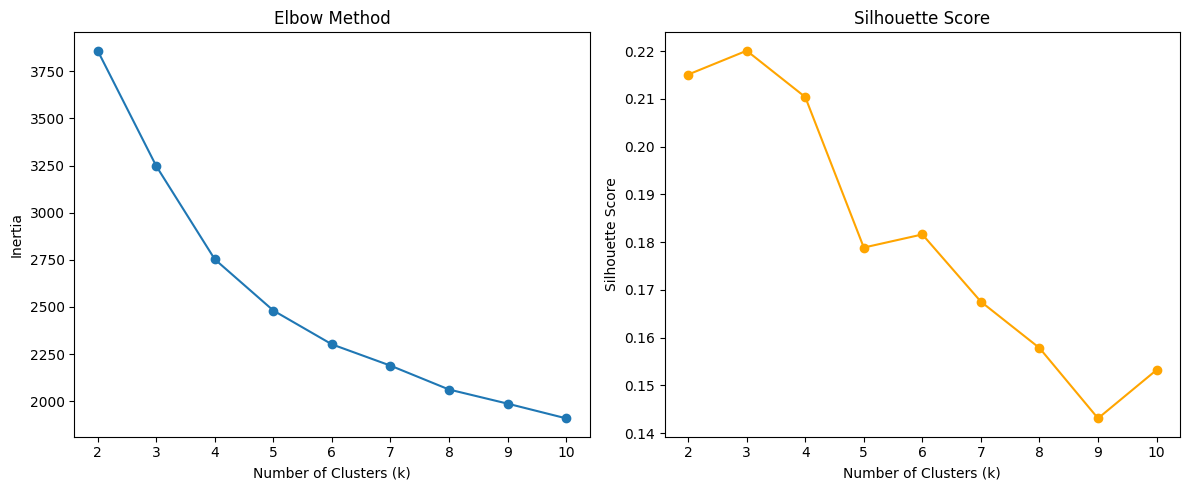

In [39]:
# Plot the Elbow (Inertia) and Silhouette Score curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

## 2. Finalize the Model with the Best k

In [40]:
best_k = 3
kmeans_final = KMeans(n_clusters=best_k,  n_init=10, random_state=42)
X['cluster'] = kmeans_final.fit_predict(X)
df["cluster"] = X["cluster"]

# Display cluster assignments for the first few records
print("Cluster assignments for the first few records:")
print(X.head())

Cluster assignments for the first few records:
   total_transactions  total_burned  usage_frequency   recency  \
0            0.861781      0.308227        -0.272757 -0.406907   
1           -0.861781     -0.965440        -0.639388  0.918325   
2            0.000000     -0.965440        -1.152671 -0.650069   
3           -1.723562     -1.602273        -1.922595  2.614378   
4           -0.430890      0.308227         0.964622 -0.631832   

   gender_name_Male  city_name_Aswan  city_name_Asyut  city_name_Beni Suef  \
0              True            False            False                False   
1             False            False            False                False   
2              True             True            False                False   
3             False            False            False                False   
4              True            False            False                False   

   city_name_Cairo  city_name_Damanhur  ...  city_name_Mansoura  \
0            False  

In [41]:
# Analyze clusters by calculating the mean of each feature per cluster
cluster_summary = X.groupby("cluster").mean()
print("\nCluster Summary (Mean Values):")
print(cluster_summary)


Cluster Summary (Mean Values):
         total_transactions  total_burned  usage_frequency   recency  \
cluster                                                                
0                  0.542603      0.816646         0.573968 -0.249152   
1                 -0.361098     -0.741203        -0.609330 -0.236194   
2                 -1.248603     -0.922019        -0.220158  2.519393   

         gender_name_Male  city_name_Aswan  city_name_Asyut  \
cluster                                                       
0                0.491770         0.067901         0.039095   
1                0.532864         0.051643         0.049296   
2                0.488636         0.022727         0.022727   

         city_name_Beni Suef  city_name_Cairo  city_name_Damanhur  ...  \
cluster                                                            ...   
0                   0.039095         0.063786            0.053498  ...   
1                   0.025822         0.075117            0.058685  ..

# 3. Segment Analysis

In [42]:
print("=== SEGMENT ANALYSIS ===")

# 1. Cluster Sizes
cluster_sizes = df['cluster'].value_counts().sort_index()
print("\nCluster Sizes (number of customers in each cluster):")
print(cluster_sizes)

# 2. Summary of Numeric Features by Cluster
numeric_features = ["total_transactions", "total_burned", "usage_frequency", "recency"]
cluster_summary = df.groupby('cluster')[numeric_features].mean().round(2)
print("\nMean of Numeric Features per Cluster:")
print(cluster_summary)

# 3. Gender Distribution
if 'gender_name' in df.columns:
    print("\nGender Distribution within Each Cluster (%):")
    gender_dist = (
        df.groupby('cluster')['gender_name']
          .value_counts(normalize=True)
          .mul(100)
          .round(2)
    )
    print(gender_dist)

# 4. City Distribution
if 'city_name' in df.columns:
    print("\nTop 5 Cities per Cluster:")
    # Loop through each cluster and show the top 5 cities
    for c in sorted(df['cluster'].unique()):
        cluster_df = df[df['cluster'] == c]
        top_cities = (
            cluster_df['city_name']
            .value_counts()
            .head(5)
        )
        print(f"\nCluster {c}:")
        print(top_cities)

# 5. one-hot encoding for city_name or gender_name
city_cols = [col for col in df.columns if col.startswith("city_name_")]
if city_cols:
    city_means = df.groupby('cluster')[city_cols].mean().mul(100).round(2)
    print("\nMean City One-Hot Encodings by Cluster (%):")
    print(city_means)

# 6. Detailed Loop for Each Cluster
for c in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == c]
    print(f"\n--- Detailed Analysis for Cluster {c} ---")
    print(f"Size: {cluster_df.shape[0]} customers")

    # mean usage frequency, total_burned, etc.
    print("Mean Numeric Features:")
    print(cluster_df[numeric_features].mean().round(2))

    # top city 
    if 'city_name' in df.columns:
        top_city = cluster_df['city_name'].value_counts().idxmax()
        print(f"Most Common City: {top_city}")

    # gender breakdown 
    if 'gender_name' in df.columns:
        gender_breakdown = (
            cluster_df['gender_name']
            .value_counts(normalize=True)
            .mul(100)
            .round(2)
        )
        print("Gender Breakdown (%):")
        print(gender_breakdown)

print("\n=== END OF SEGMENT ANALYSIS ===")

=== SEGMENT ANALYSIS ===

Cluster Sizes (number of customers in each cluster):
cluster
0    486
1    426
2     88
Name: count, dtype: int64

Mean of Numeric Features per Cluster:
         total_transactions  total_burned  usage_frequency  recency
cluster                                                            
0                      6.26          3.80             0.65    74.95
1                      4.16          1.35             0.34    77.08
2                      2.10          1.07             0.44   530.38

Mean City One-Hot Encodings by Cluster (%):
         city_name_Aswan  city_name_Asyut  city_name_Beni Suef  \
cluster                                                          
0                   6.79             3.91                 3.91   
1                   5.16             4.93                 2.58   
2                   2.27             2.27                 6.82   

         city_name_Cairo  city_name_Damanhur  city_name_Damietta  \
cluster                              

# 4. Coupon Strategy Recommendations

In [43]:
# Group by cluster and compute average metrics
cluster_summary = df.groupby("cluster").agg({
    "usage_frequency": "mean",      # ratio of burned to total transactions
    "total_transactions": "mean",
    "total_burned": "mean",
    "recency": "mean"               # average days since last transaction
}).reset_index()

print("=== Cluster Summary ===")
print(cluster_summary)

=== Cluster Summary ===
   cluster  usage_frequency  total_transactions  total_burned     recency
0        0         0.648522            6.259259      3.798354   74.950617
1        1         0.341141            4.161972      1.352113   77.082160
2        2         0.442235            2.102273      1.068182  530.375000


In [44]:
# Define a function to generate coupon strategy recommendations based on average metrics for each cluster.
def generate_recommendation(row):
    # These thresholds are examples
    if row['usage_frequency'] > 0.6 and row['recency'] < 30:
        return ("High engagement segment: These customers use coupons frequently and are active. " 
                "Recommend offering loyalty rewards, exclusive deals, or VIP coupons to retain their interest.")
    elif row['usage_frequency'] < 0.3 and row['recency'] > 60:
        return ("Low engagement segment: These customers rarely use coupons and haven't been active recently. " 
                "Recommend sending reactivation coupons or introductory offers to encourage trial.")
    else:
        return ("Moderate engagement segment: Customers with average coupon usage and activity. " 
                "Recommend targeted personalized discounts to boost their frequency and overall loyalty.")

# Apply the function to each row of the cluster summary
cluster_summary['recommendation'] = cluster_summary.apply(generate_recommendation, axis=1)

print("\n=== Coupon Strategy Recommendations by Cluster ===")
print(cluster_summary[['cluster', 'recommendation']])


=== Coupon Strategy Recommendations by Cluster ===
   cluster                                     recommendation
0        0  Moderate engagement segment: Customers with av...
1        1  Moderate engagement segment: Customers with av...
2        2  Moderate engagement segment: Customers with av...


# 5. Trying Other Clustering Methods

## DBSCAN

In [45]:
# DBSCAN parameters (eps and min_samples).
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Count clusters (ignore noise label -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN found {n_clusters_dbscan} clusters.")

if n_clusters_dbscan > 1:
    sil_score_dbscan = silhouette_score(X, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {sil_score_dbscan:.3f}")
else:
    print("DBSCAN did not form meaningful clusters (or found only noise).")

DBSCAN found 3 clusters.
DBSCAN Silhouette Score: -0.281


## Agglomerative Clustering (Hierarchical Clustering)

In [46]:
# Choose a number of clusters: 3 clusters.
agg_clust = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clust.fit_predict(X)

print("Agglomerative Clustering labels:", np.unique(agg_labels))
sil_score_agg = silhouette_score(X, agg_labels)
print(f"Agglomerative Clustering Silhouette Score: {sil_score_agg:.3f}")

Agglomerative Clustering labels: [0 1 2]
Agglomerative Clustering Silhouette Score: 0.259


## Visualize the Clusters using PCA for Dimensionality Reduction

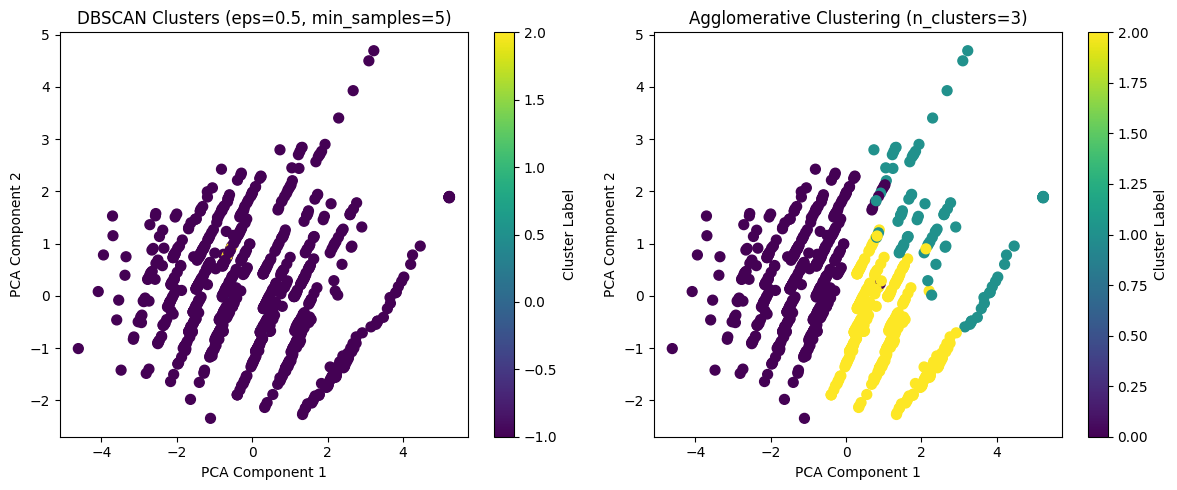

In [47]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 5))

# Plot DBSCAN Clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title("DBSCAN Clusters (eps=0.5, min_samples=5)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")

# Plot Agglomerative Clustering Results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', s=50)
plt.title("Agglomerative Clustering (n_clusters=3)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")

plt.tight_layout()
plt.show()

# 6. Presenting Your Findings

## 1. Visualize Clusters using PCA Scatter Plot

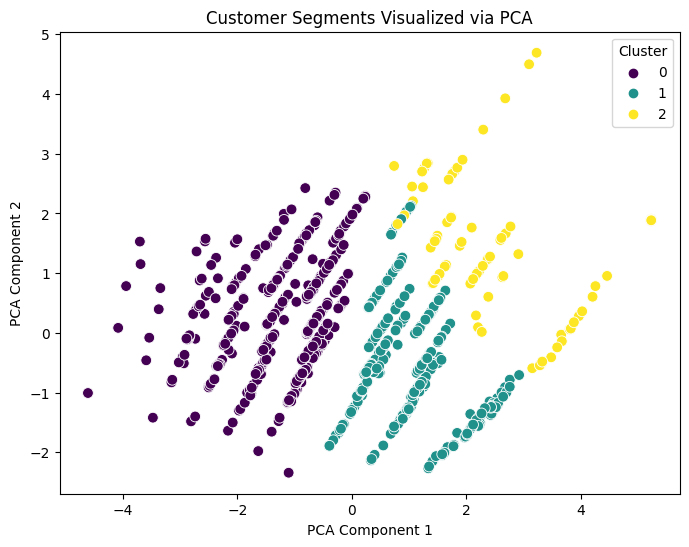

In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=df, palette='viridis', s=60)
plt.title("Customer Segments Visualized via PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

## 2. Cluster Summary Table

In [49]:
cluster_summary = df.groupby('cluster').agg({
    'total_transactions': 'mean',
    'total_burned': 'mean',
    'usage_frequency': 'mean',
    'recency': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'})

print("=== Cluster Summary (Mean Values) ===")
print(cluster_summary)

=== Cluster Summary (Mean Values) ===
         total_transactions  total_burned  usage_frequency     recency  \
cluster                                                                  
0                  6.259259      3.798354         0.648522   74.950617   
1                  4.161972      1.352113         0.341141   77.082160   
2                  2.102273      1.068182         0.442235  530.375000   

         num_customers  
cluster                 
0                  486  
1                  426  
2                   88  


## 3. Distribution of Usage Frequency per Cluster

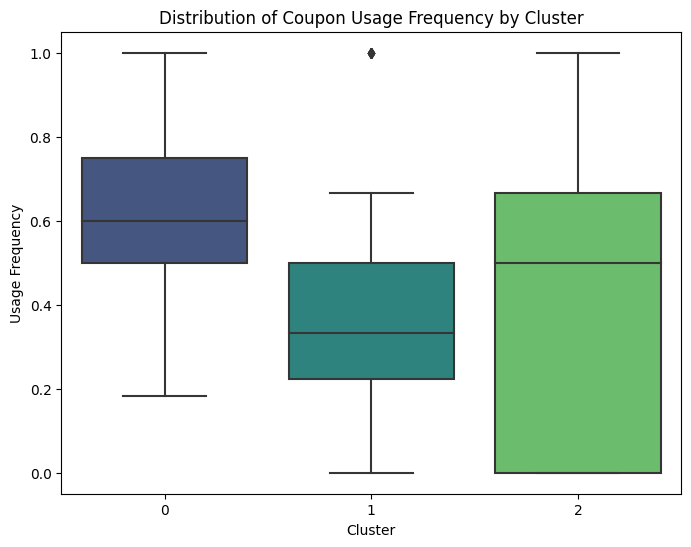

In [50]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='usage_frequency', data=df, palette='viridis')
plt.title("Distribution of Coupon Usage Frequency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Usage Frequency")
plt.show()

## 4. Number of Customers per Cluster

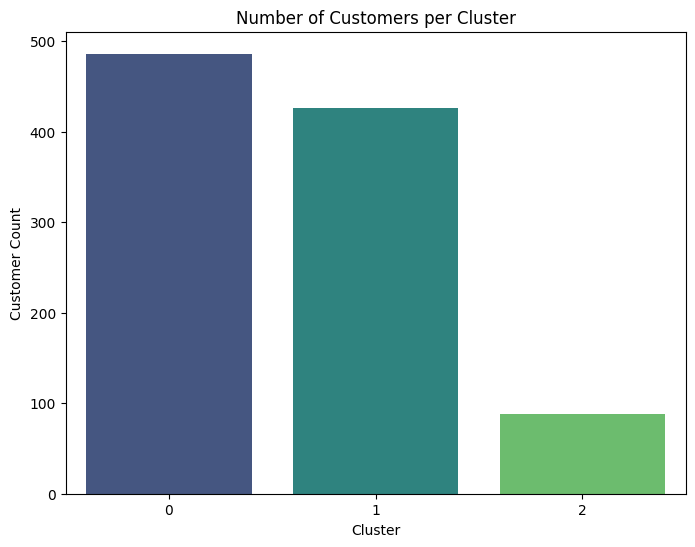

In [51]:
cluster_counts = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Customer Count")
plt.show()

## 5. Coupon Strategy Recommendations based on Cluster Metrics

In [52]:
# function to generate recommendations for each cluster based on average behavior.
def get_recommendation(row):
    if row['usage_frequency'] > 0.6 and row['recency'] < 30:
        return "High engagement: Offer loyalty rewards and exclusive deals."
    elif row['usage_frequency'] < 0.3 and row['recency'] > 60:
        return "Low engagement: Send reactivation offers or introductory discounts."
    else:
        return "Moderate engagement: Provide targeted personalized discounts."
        
cluster_summary['recommendation'] = cluster_summary.apply(get_recommendation, axis=1)

print("\n=== Coupon Strategy Recommendations by Cluster ===")
print(cluster_summary[['recommendation']])


=== Coupon Strategy Recommendations by Cluster ===
                                            recommendation
cluster                                                   
0        Moderate engagement: Provide targeted personal...
1        Moderate engagement: Provide targeted personal...
2        Moderate engagement: Provide targeted personal...
